In [1]:
from PIL import Image
import numpy as np

# Read TIFF images using Pillow
img = np.array(Image.open("data/images/01_t000.tif"))
msk = np.array(Image.open("data/masks/01_t000.tif"))

print(img.shape, img.dtype, msk.shape, msk.dtype, np.unique(msk)[:5])

(1024, 1024) uint8 (1024, 1024) uint16 [0 1 2 3 4]


In [2]:
import matplotlib.pyplot as plt

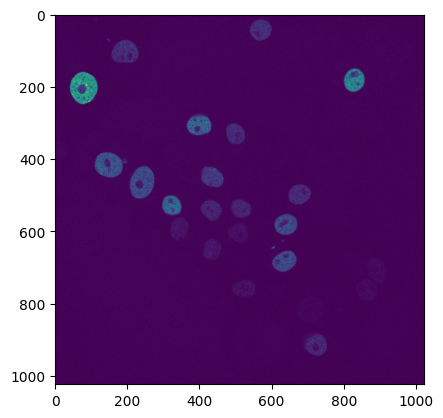

In [3]:
plt.imshow(img)


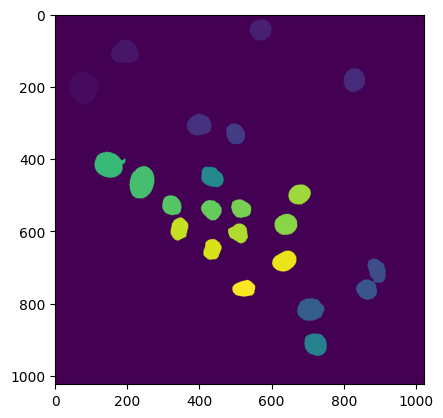

In [4]:
plt.imshow(msk)

In [ ]:
import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch.nn as nn

def conv_block(inp_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(inp_ch, out_ch, 3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

In [ ]:
class Unet(nn.Module):

    def __init__(self, input_ch=3, n_class=1, base_ch=64, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.conv = conv_block(input_ch, base_ch)

        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            conv_block(base_ch, base_ch * 2)
        )

        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            conv_block(base_ch * 2, base_ch * 4)
        )

        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            conv_block(base_ch * 4, base_ch * 8)
        )

        self.up1 = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, 2, stride=2)
        self.conv_up1 = conv_block(base_ch * 8, base_ch * 4)

        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)
        self.conv_up2 = conv_block(base_ch * 4, base_ch * 2)

        self.up3 = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)
        self.conv_up3 = conv_block(base_ch * 2, base_ch)

        self.out = nn.Conv2d(base_ch, n_class, 1)

    def forward(self, x):
        # Encoder
        c1 = self.conv(x)
        c2 = self.down1(c1)
        c3 = self.down2(c2)
        c4 = self.down3(c3)

        # Decoder
        u1 = self.up1(c4)
        u1 = torch.cat([u1, c3], dim=1)
        u1 = self.conv_up1(u1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, c2], dim=1)
        u2 = self.conv_up2(u2)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, c1], dim=1)
        u3 = self.conv_up3(u3)

        out = self.out(u3)
        return out


In [ ]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image



class CellTrackingDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]))
        msk = np.array(Image.open(self.mask_paths[idx]))

        if len(img.shape) == 2:
            img = img[..., np.newaxis]

        img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0
        msk = torch.from_numpy(msk).float().unsqueeze(0)

        if self.transform:
            img = self.transform(img)
            msk = self.transform(msk)

        return img, msk

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim


class UnetTrainer:
    def __init__(self, model, train_loader, val_loader=None, lr=1e-3, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.BCEWithLogitsLoss()
        self.history = {'train_loss': [], 'val_loss': []}

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        accumulation_steps = 4 

        for idx, (images, masks) in enumerate(self.train_loader):
            images = images.to(self.device)
            masks = masks.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, masks) / accumulation_steps
            loss.backward()
            if (idx + 1) % accumulation_steps == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()
        
            total_loss += loss.item() * accumulation_steps
            torch.cuda.empty_cache()

        return total_loss / len(self.train_loader)

    def validate(self):
        if self.val_loader is None:
            return None

        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for images, masks in self.val_loader:
                images = images.to(self.device)
                masks = masks.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                total_loss += loss.item()

        return total_loss / len(self.val_loader)

    def train(self, epochs):
        for epoch in range(epochs):
            train_loss = self.train_epoch()
            self.history['train_loss'].append(train_loss)

            val_loss = self.validate()
            if val_loss is not None:
                self.history['val_loss'].append(val_loss)
                print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
            else:
                print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}")

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))

In [ ]:
import glob

image_paths = sorted(glob.glob("data/images/*.tif"))
mask_paths = sorted(glob.glob("data/masks/*.tif"))

print(f"Images: {len(image_paths)}, Masks: {len(mask_paths)}")

In [ ]:
dataset = CellTrackingDataset(image_paths, mask_paths)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Dataset size: {len(dataset)}")
print(f"Batches: {len(train_loader)}")


In [ ]:
model = Unet(input_ch=1, n_class=1, base_ch=32)
trainer = UnetTrainer(model, train_loader, val_loader=None, lr=1e-3, device=device)

In [ ]:
trainer.train(epochs=10)

In [ ]:
# trainer.save_model('unet_celltrack.pth')

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.plot(trainer.history['train_loss'], label='Train Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
im = "data/tests/01/t000.tif"
im_t = np.array(Image.open(im))
plt.imshow(im_t)

In [ ]:
im = "predictions/masks/t000_pred.png"
im_t = np.array(Image.open(im))
plt.imshow(im_t)